# Spot the spots

## Introduction to Machine Learning on NeSI Workshop

This notebook shows how machine learning can be applied to feature detection. You're faced with the tedious task of counting "spots" present in a large number of data samples. The spots may represent pictures of fishes, tropical cyclones, skin moles, tumours or black holes - you choose.

*In this version the number of spots are classified into separate categories using a pretrained model.*

## Requirements

You will need:
    
 * Python 3
 * NumPy
 * Matplotlib
 * TensorFlow 2.0

## Input parameters for the dataset

In [1]:
# dataset input values - feel free to change
numTrain = 1000     # number of training samples
numTest = 100       # number of testing samples
numCells = 128       # the data have size numCells x numCells
maxNumSpots = 5     # the maximum number of spots 0...maxNumSpots
categories = ['<=1', '==2', '==3', '>=4'] # classification categories (1 spot or less, 2 spots, etc.)

## Reproducible results for testing the model

Setting the random seeds ensures you will get the same results when running this notebook from the start (Restart and Run All). Feel free change the seed value or comment out this block to test your model on different data.

In [2]:
random_seed = 123

import numpy as np
np.random.seed(random_seed)

import tensorflow as tf
tf.random.set_seed(random_seed)

import random
random.seed(random_seed)

## Where the code will run

Uncomment these commands to show what devices are available and are being used.

In [3]:
# list available GPUs
#tf.config.experimental.list_physical_devices()

In [4]:
# print info about which device operations are running on
#tf.debugging.set_log_device_placement(True)

## Some convenience functions

### Function to generate random samples

Each sample is a 2d image/data with spots at random locations.

In [5]:
# define the 2d grid
xs = np.linspace(0., 1., numCells)
ys = np.linspace(0., 1., numCells)
xxs, yys = np.meshgrid(xs, ys)

def generateRandomSamples(numSamples):
    """
    Generate samples containing random data with spots (Gaussian field over zero background)
    @param numSamples number of samples to generate
    @return samplesInput array containing data for the samples
    @return samplesOutput vector with the correct number of spots in each sample
    
    """
    # allocate memory, note the colour channel
    samplesInput = np.zeros((numSamples, numCells, numCells, 3), np.float32)
    samplesOutput = np.zeros((numSamples,), np.int8)
    data = np.zeros((numCells, numCells), np.float32)
    # create the samples
    for sample in range(numSamples):
        numSpots = int(maxNumSpots * np.random.random() + 0.5)
        data[:] = 0 
        for i in range(numSpots):
            # random radius
            rad = 0.1 + 0.0*np.random.random()  # currently fixed radius of 0.1
            # random location
            x0, y0 = 0.1 + 0.8*np.random.random(), 0.1 + 0.8*np.random.random()
            data += np.exp( -((xxs - x0)**2 + (yys - y0)**2)/rad**2 )
        # normalize, filter nans
        maxVal = data.max()
        if maxVal != 0:
            data /= maxVal
        data = np.nan_to_num(data)
        samplesInput[sample, :, :, 0] = data
        samplesInput[sample, :, :, 1] = 0.8*data
        samplesInput[sample, :, :, 2] = 0.7*data
        # map the number of spots to one of our categories (classIndex is 
        # in the range 0...len(categories) - 1)
        classIndex = [eval(f'{numSpots}' + c) for c in categories].index(True)
        samplesOutput[sample] = classIndex
  
    return samplesInput, samplesOutput

### Function to plot the data

In [6]:
import matplotlib.pylab as plt

numCols = 5
def plotData(iBeg, iEnd, dataInput, dataOutput, dataReferenceOutput=[]):
    """
    Plot the data
    @param iBeg start index in the dataset (list of 2D data)
    @param iEnd one past the last index in the dataset
    @param dataInput dataset
    @param dataOutput number of spots for each data array
    @param dataReferenceOutput correct number of spots for each data array
  
    """
    numPlots = iEnd - iBeg
    numRows = numPlots // numCols
    if numPlots % numCols > 0:
        numRows += 1
    for i in range(iBeg, iEnd):
        plt.subplot(numRows, numCols, i - iBeg + 1)
        plt.imshow(dataInput[i, ...], cmap='YlOrBr')
        plt.axis('off')
        txt = f'{categories[dataOutput[i]]}'
        if len(dataReferenceOutput) > 0:
            txt += f' (ex {dataReferenceOutput[i]})'
        plt.title(txt, fontsize=8)
    plt.show()

## Creating the training samples

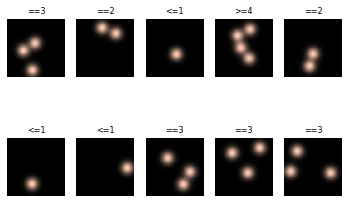

In [7]:
trainInput, trainOutput = generateRandomSamples(numTrain)
plotData(0, min(10, numTrain), trainInput, trainOutput)  # plotting a subset of the training dataset

## Creating the test samples

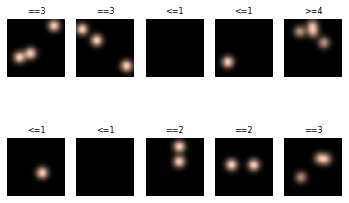

In [8]:
testInput, testOutput = generateRandomSamples(numTest)
plotData(0, min(10, numTest), testInput, testOutput)  # plotting a subset of the testing dataset

## Creating a neural network

In [11]:
from tensorflow import keras

# download the model with pretrained weights using the imagenet set of data.
# include_header = False allows us to set our own image size
model0 = keras.applications.vgg16.VGG16(include_top=False,
                                       weights='imagenet',
                                       input_shape=(numCells, numCells, 3))

# add classification layer(s)
x = model0.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(len(categories), activation='softmax')(x)

# combine the pretrained model with our classification
model = keras.models.Model(inputs=model0.input, outputs=x)

# only adjust the weights from the last dense layer, keep all other 
# weights fixed
print(f' number of layers: {len(model.layers)}')
for layer in model.layers[:len(model.layers)-1]:
    layer.trainable = False

# check the topology, verify that only the last layer is trainable
model.summary()

# configure the model for training
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

 number of layers: 21
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 3

## Training the neural network

The input is a 4d tensor which should have shape (samples, rows, cols, channels).

In [12]:
numEpochs = 10
history = model.fit(trainInput,
                    trainOutput, 
                    epochs=numEpochs, 
                    validation_split=0.2, # 80 percent training, 20% testing
                    batch_size=32) # number of training examples used before the weights are updated

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 114s 142ms/sample - loss: 1.1719 - accuracy: 0.4850 - val_loss: 0.9891 - val_accuracy: 0.5650
Epoch 2/10
800/800 [==============================] - 114s 142ms/sample - loss: 0.8551 - accuracy: 0.6300 - val_loss: 0.8476 - val_accuracy: 0.7150
Epoch 3/10
800/800 [==============================] - 111s 138ms/sample - loss: 0.7569 - accuracy: 0.6925 - val_loss: 0.7528 - val_accuracy: 0.7600
Epoch 4/10
800/800 [==============================] - 109s 136ms/sample - loss: 0.7094 - accuracy: 0.7237 - val_loss: 0.7196 - val_accuracy: 0.7550
Epoch 5/10
800/800 [==============================] - 107s 134ms/sample - loss: 0.6681 - accuracy: 0.7275 - val_loss: 0.7056 - val_accuracy: 0.6800
Epoch 6/10
800/800 [==============================] - 109s 137ms/sample - loss: 0.6200 - accuracy: 0.7812 - val_loss: 0.6851 - val_accuracy: 0.7600
Epoch 7/10
800/800 [==============================] - 107s 134ms/s

## Plotting the model performance

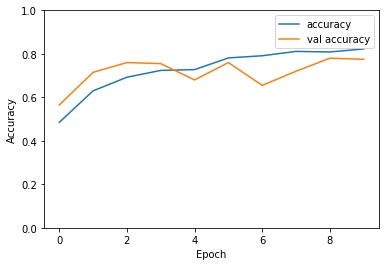

In [13]:
# plot the loss against epoch
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='best')
plt.show()

## Predicting the the number of spots in each test sample

In [14]:
predictionProbs = model.predict(testInput)
predClassInds = np.argmax(predictionProbs, axis=1)
# compute the errors: difference between predictions and testOuput
errors = predClassInds - testOutput
numErrors = (errors != 0).sum()
print(errors)
print(f'num errors = {numErrors} ({100*numErrors/numTest} %)')

[ 1  0  0  0  0  0  0  1  1 -1  0  0  0  0 -1  0  1  0  0  0  0  0  1  0
  0  0  0  0  0  0  2  0  0 -1  0  0  0  0 -2  0 -2  1  0  0  0  1  0  1
  0  0  0  0  0  0  1  0  0  0  0  1  1  0 -2  1  0  0  0  0  0  0  0  0
  1  0  0  0  0  0  0  0  0  0  0  0 -1  0 -2  0 -2  0  0  0  0  0  0  0
  0  0  0  0]
num errors = 23 (23.0 %)



Plotting data for which the predictions are wrong

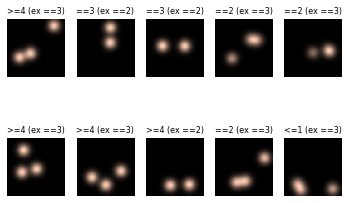

In [15]:
inds = np.nonzero(errors != 0)[0]
failuresInput = testInput[inds, :]
failuresOutput = predClassInds[inds]
correctOutput = [categories[i] for i in testOutput[inds]]
numFailures = len(failuresOutput)
plotData(0, min(10, numFailures), failuresInput, failuresOutput, correctOutput)

## Exercise

Try to improve our initial model. Feel free to change anything above, such as:

* the pretrained [model](https://keras.io/applications/)
* appending dense layers before the classification layer
* the number of layers for which the weights are kept fixed
* adjust other parameters, e.g. the size of the input dataset

See if you can reduce the error.

Once you have improved improved your model, try changing the random seed and see if the behaviour changes.